### ti


In [1]:
!pip install renishawWiRE
import numpy as np
import matplotlib.pyplot as plt
from renishawWiRE import WDFReader
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import glob

# for deleting cosmic rays
from scipy.ndimage import median_filter


In [2]:
# loading files to colab
from google.colab import files

uploaded = files.upload()


Saving ad-785-nd10-5s-1200-HR-1.wdf to ad-785-nd10-5s-1200-HR-1.wdf
Saving cht_dark-785-1200-nd10-5s_32x32_map.wdf to cht_dark-785-1200-nd10-5s_32x32_map.wdf
Saving cht_light-785-1200-nd10-5s_32x32_map.wdf to cht_light-785-1200-nd10-5s_32x32_map.wdf


In [3]:
# reading wdf file
def read_wdf_file(filename):
    reader = WDFReader(filename)
    spectra = reader.spectra  # numpy array: shape (num_points, num_channels)
    xdata = reader.xdata  # wavenumbers (Raman shift)|

    # Для картирования также получаем координаты
    try:
        xpos = reader.xpos  # X-координаты точек
        ypos = reader.ypos  # Y-координаты точек
        return spectra, xdata, xpos, ypos
    except:
        # Для single-point измерений координат может не быть
        return spectra, xdata, None, None

# Чтение всех .wdf файлов в текущей папке
filenames = glob.glob('*.wdf')
print(f"Найдено файлов: {len(filenames)}")

data_list = []
for f in filenames:
    print(f"Загрузка файла: {f}")
    data = read_wdf_file(f)
    data_list.append(data)
    print(f"  Размер спектров: {data[0].shape}")


Найдено файлов: 3
Загрузка файла: cht_light-785-1200-nd10-5s_32x32_map.wdf
  Размер спектров: (32, 32, 1011)
Загрузка файла: cht_dark-785-1200-nd10-5s_32x32_map.wdf
  Размер спектров: (32, 32, 1011)
Загрузка файла: ad-785-nd10-5s-1200-HR-1.wdf
  Размер спектров: (32, 32, 1011)


In [4]:
# Блок 4: Удаление полиномиального фона из спектров
def remove_poly_background(spectra, degree=5):
    """
    Удаление полиномиального фона из спектров
    spectra: array формата (n_spectra, n_channels) или (x, y, n_channels)
    """
    # Если 3D массив (картирование), преобразуем в 2D
    original_shape = spectra.shape
    if len(original_shape) == 3:
        spectra_2d = spectra.reshape(-1, original_shape[-1])
    else:
        spectra_2d = spectra

    corrected = np.zeros_like(spectra_2d)
    x = np.arange(spectra_2d.shape[1])

    for i, spectrum in enumerate(spectra_2d):
        # Полиномиальная аппроксимация фона
        coeffs = np.polyfit(x, spectrum, degree)
        background = np.polyval(coeffs, x)
        corrected[i] = spectrum - background

    # Возвращаем в исходную форму
    if len(original_shape) == 3:
        corrected = corrected.reshape(original_shape)

    return corrected

# Применяем к обоим датасетам
print("Удаление фона из первого датасета (dark)...")
spectra_dark_cleaned = remove_poly_background(data_list[0][0])
print(f"Результат: {spectra_dark_cleaned.shape}")

print("\nУдаление фона из второго датасета (light)...")
spectra_light_cleaned = remove_poly_background(data_list[1][0])
print(f"Результат: {spectra_light_cleaned.shape}")


Удаление фона из первого датасета (dark)...
Результат: (32, 32, 1011)

Удаление фона из второго датасета (light)...
Результат: (32, 32, 1011)


In [5]:
# Блок 5: Удаление выбросов (cosmic ray removal)
def remove_cosmic_rays(spectra, threshold=3.0):
    """
    Удаление космических лучей на основе анализа производной
    spectra: array формата (n_spectra, n_channels) или (x, y, n_channels)
    threshold: порог для определения выброса (в единицах std)
    """
    original_shape = spectra.shape
    if len(original_shape) == 3:
        spectra_2d = spectra.reshape(-1, original_shape[-1])
    else:
        spectra_2d = spectra.copy()

    cleaned = np.zeros_like(spectra_2d)

    for i, spectrum in enumerate(spectra_2d):
        # Вычисляем производную для обнаружения резких скачков
        deriv = np.gradient(spectrum)
        deriv_smooth = savgol_filter(deriv, window_length=5, polyorder=2)
        diff = np.abs(deriv - deriv_smooth)

        # Определяем пороговое значение
        threshold_val = threshold * np.std(diff)
        spikes = diff > threshold_val

        # Интерполируем значения в местах выбросов
        spectrum_clean = spectrum.copy()
        if np.any(spikes):
            indices = np.arange(len(spectrum))
            spectrum_clean[spikes] = np.interp(indices[spikes],
                                                indices[~spikes],
                                                spectrum[~spikes])
        cleaned[i] = spectrum_clean

    if len(original_shape) == 3:
        cleaned = cleaned.reshape(original_shape)

    return cleaned

print("Удаление cosmic rays из dark датасета...")
spectra_dark_cr_removed = remove_cosmic_rays(spectra_dark_cleaned)
print(f"Результат: {spectra_dark_cr_removed.shape}")

print("\nУдаление cosmic rays из light датасета...")
spectra_light_cr_removed = remove_cosmic_rays(spectra_light_cleaned)
print(f"Результат: {spectra_light_cr_removed.shape}")


Удаление cosmic rays из dark датасета...
Результат: (32, 32, 1011)

Удаление cosmic rays из light датасета...
Результат: (32, 32, 1011)


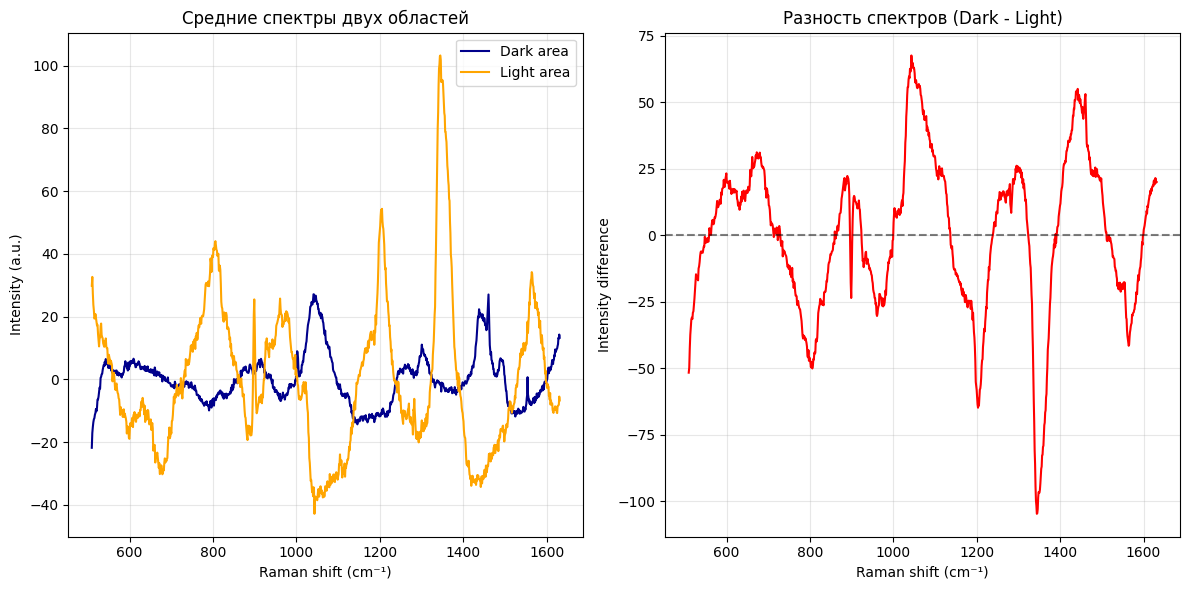

In [6]:
# Блок 6: Визуализация средних спектров для сравнения
def plot_average_spectra_comparison(dark_data, light_data, wavenumbers):
    """
    Построение графика средних спектров для двух областей
    """
    # Преобразуем 3D в 2D и вычисляем среднее
    dark_2d = dark_data.reshape(-1, dark_data.shape[-1])
    light_2d = light_data.reshape(-1, light_data.shape[-1])

    mean_dark = np.mean(dark_2d, axis=0)
    mean_light = np.mean(light_2d, axis=0)

    std_dark = np.std(dark_2d, axis=0)
    std_light = np.std(light_2d, axis=0)

    plt.figure(figsize=(12, 6))

    # График средних спектров
    plt.subplot(1, 2, 1)
    plt.plot(wavenumbers, mean_dark, label='Dark area', color='darkblue', linewidth=1.5)
    plt.plot(wavenumbers, mean_light, label='Light area', color='orange', linewidth=1.5)
    plt.xlabel('Raman shift (cm⁻¹)')
    plt.ylabel('Intensity (a.u.)')
    plt.title('Средние спектры двух областей')
    plt.legend()
    plt.grid(alpha=0.3)

    # График разности спектров
    plt.subplot(1, 2, 2)
    difference = mean_dark - mean_light
    plt.plot(wavenumbers, difference, color='red', linewidth=1.5)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.xlabel('Raman shift (cm⁻¹)')
    plt.ylabel('Intensity difference')
    plt.title('Разность спектров (Dark - Light)')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

# Используем wavenumbers из data_list
wavenumbers = data_list[0][1]  # xdata из первого файла
plot_average_spectra_comparison(spectra_dark_cr_removed,
                                spectra_light_cr_removed,
                                wavenumbers)


In [7]:
# Блок 7: Нормализация данных для PCA и ML
def normalize_spectra_map(spectra, method='standard'):
    """
    Нормализация спектров
    method: 'standard' (StandardScaler) или 'minmax' или 'vector' (L2 norm)
    """
    original_shape = spectra.shape
    spectra_2d = spectra.reshape(-1, original_shape[-1])

    if method == 'standard':
        scaler = StandardScaler()
        spectra_norm = scaler.fit_transform(spectra_2d)
    elif method == 'minmax':
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
        spectra_norm = scaler.fit_transform(spectra_2d)
    elif method == 'vector':
        # L2 нормализация (каждый спектр к единичному вектору)
        from sklearn.preprocessing import normalize
        spectra_norm = normalize(spectra_2d, norm='l2')
    else:
        spectra_norm = spectra_2d

    return spectra_norm, original_shape

print("Нормализация dark датасета...")
dark_norm, dark_shape = normalize_spectra_map(spectra_dark_cr_removed, method='standard')
print(f"Результат: {dark_norm.shape}")

print("\nНормализация light датасета...")
light_norm, light_shape = normalize_spectra_map(spectra_light_cr_removed, method='standard')
print(f"Результат: {light_norm.shape}")

# Объединяем оба датасета для совместного анализа
all_spectra_norm = np.vstack([dark_norm, light_norm])
labels = np.array([0]*dark_norm.shape[0] + [1]*light_norm.shape[0])  # 0=dark, 1=light
print(f"\nОбщий датасет: {all_spectra_norm.shape}, labels: {labels.shape}")


Нормализация dark датасета...
Результат: (1024, 1011)

Нормализация light датасета...
Результат: (1024, 1011)

Общий датасет: (2048, 1011), labels: (2048,)


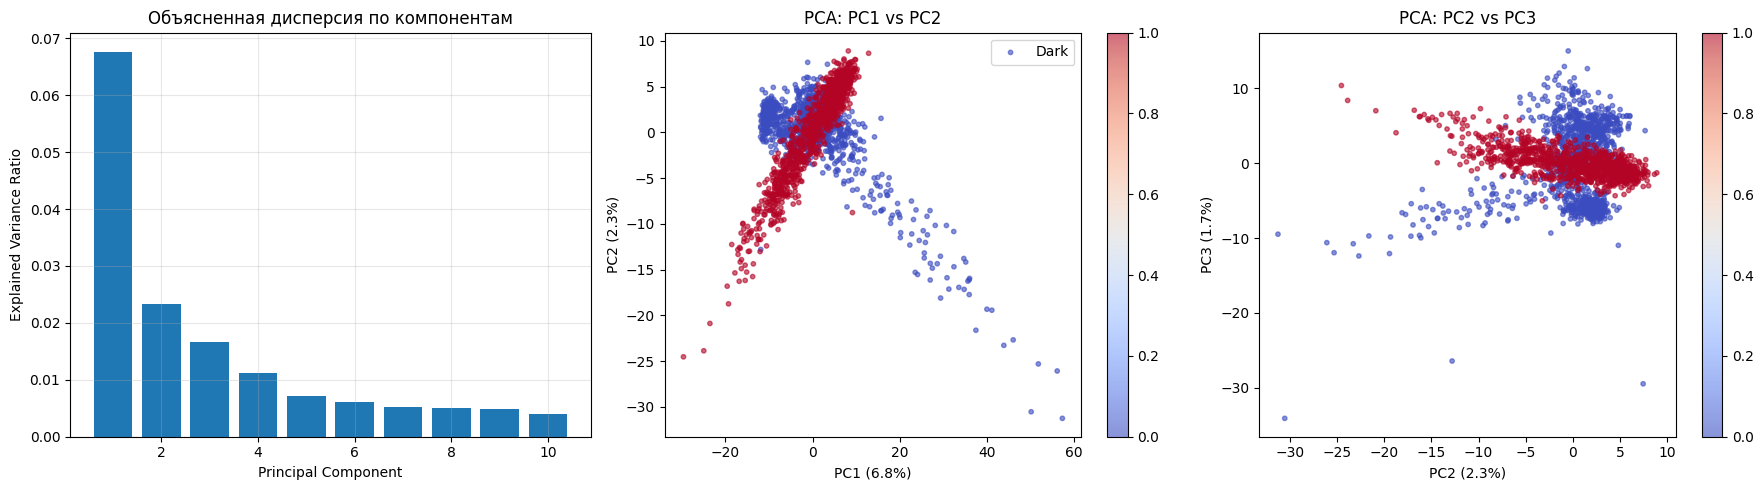


Первые 3 компоненты объясняют 10.8% дисперсии


In [8]:
# Блок 8: PCA анализ и визуализация
pca = PCA(n_components=10)  # Сначала получим 10 компонент
pca_result = pca.fit_transform(all_spectra_norm)

# Процент объясненной дисперсии
explained_var = pca.explained_variance_ratio_
cumsum_var = np.cumsum(explained_var)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# График объясненной дисперсии
axes[0].bar(range(1, 11), explained_var[:10])
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Объясненная дисперсия по компонентам')
axes[0].grid(alpha=0.3)

# PCA scatter plot (PC1 vs PC2)
scatter1 = axes[1].scatter(pca_result[:, 0], pca_result[:, 1],
                          c=labels, cmap='coolwarm', alpha=0.6, s=10)
axes[1].set_xlabel(f'PC1 ({explained_var[0]*100:.1f}%)')
axes[1].set_ylabel(f'PC2 ({explained_var[1]*100:.1f}%)')
axes[1].set_title('PCA: PC1 vs PC2')
axes[1].legend(['Dark', 'Light'])
plt.colorbar(scatter1, ax=axes[1])

# PCA scatter plot (PC2 vs PC3)
scatter2 = axes[2].scatter(pca_result[:, 1], pca_result[:, 2],
                          c=labels, cmap='coolwarm', alpha=0.6, s=10)
axes[2].set_xlabel(f'PC2 ({explained_var[1]*100:.1f}%)')
axes[2].set_ylabel(f'PC3 ({explained_var[2]*100:.1f}%)')
axes[2].set_title('PCA: PC2 vs PC3')
plt.colorbar(scatter2, ax=axes[2])

plt.tight_layout()
plt.show()

print(f"\nПервые 3 компоненты объясняют {cumsum_var[2]*100:.1f}% дисперсии")


Запуск t-SNE (может занять несколько минут)...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


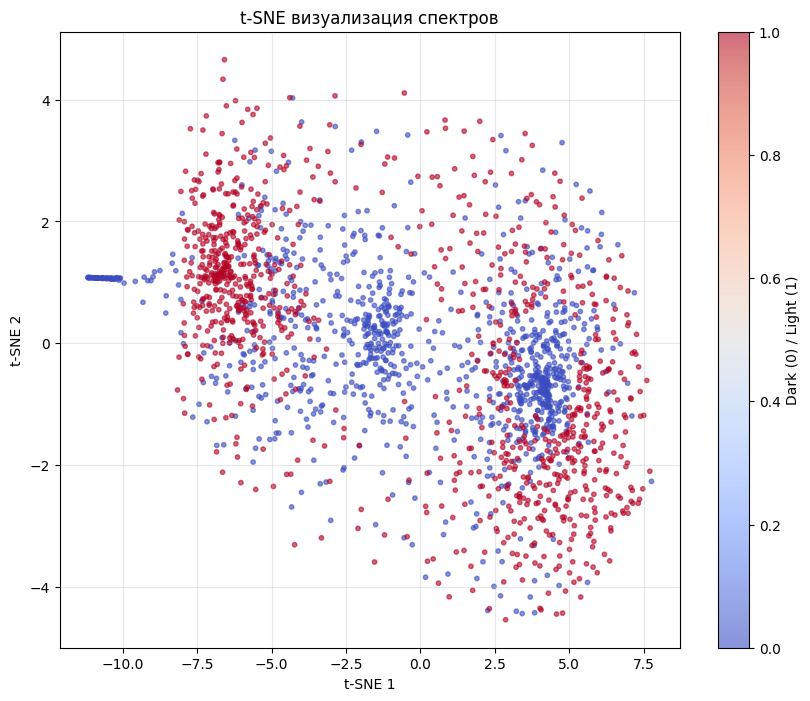

In [9]:
# Блок 9: t-SNE визуализация
from sklearn.manifold import TSNE

# Используем меньше точек для t-SNE (он медленный на больших данных)
# Или используем PCA предобработку
n_samples = all_spectra_norm.shape[0]
if n_samples > 5000:
    # Используем PCA для снижения размерности перед t-SNE
    pca_50 = PCA(n_components=50)
    data_for_tsne = pca_50.fit_transform(all_spectra_norm)
    print(f"Использована PCA предобработка: {data_for_tsne.shape}")
else:
    data_for_tsne = all_spectra_norm

print("Запуск t-SNE (может занять несколько минут)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_result = tsne.fit_transform(data_for_tsne)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1],
                     c=labels, cmap='coolwarm', alpha=0.6, s=10)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE визуализация спектров')
plt.colorbar(scatter, label='Dark (0) / Light (1)')
plt.grid(alpha=0.3)
plt.show()


Train set: (1433, 1011), Test set: (615, 1011)

=== Logistic Regression ===
              precision    recall  f1-score   support

        Dark       0.29      0.28      0.28       308
       Light       0.29      0.29      0.29       307

    accuracy                           0.29       615
   macro avg       0.29      0.29      0.29       615
weighted avg       0.29      0.29      0.29       615

Cross-validation accuracy: 0.145 (+/- 0.013)

=== Random Forest ===
              precision    recall  f1-score   support

        Dark       1.00      0.99      1.00       308
       Light       0.99      1.00      1.00       307

    accuracy                           1.00       615
   macro avg       1.00      1.00      1.00       615
weighted avg       1.00      1.00      1.00       615

Cross-validation accuracy: 0.999 (+/- 0.001)


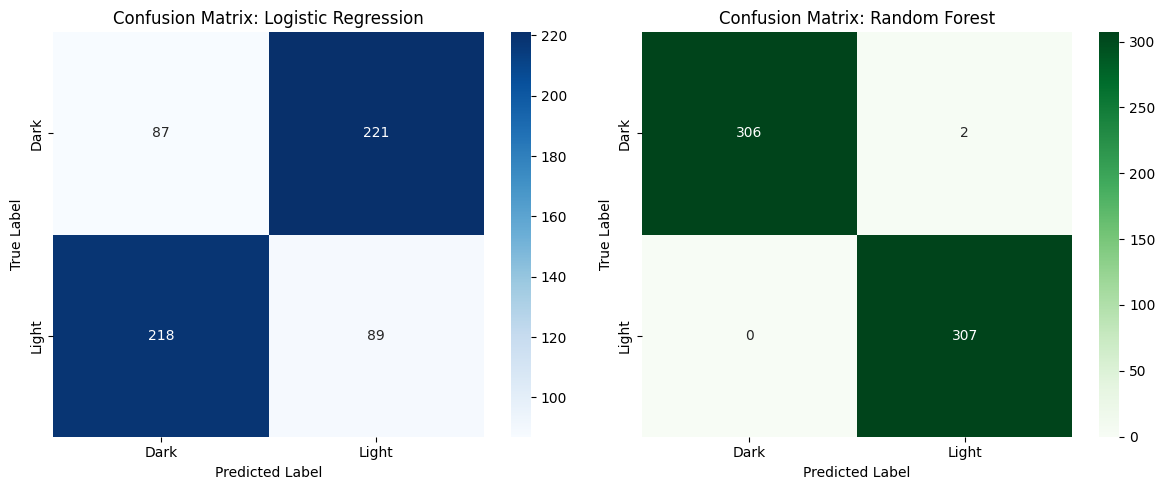

In [10]:
# Блок 10: Классификация с оценкой качества
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    all_spectra_norm, labels, test_size=0.3, random_state=42, stratify=labels
)

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

# Модель 1: Logistic Regression
print("\n=== Logistic Regression ===")
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print(classification_report(y_test, y_pred_lr, target_names=['Dark', 'Light']))

# Cross-validation
cv_scores_lr = cross_val_score(lr, all_spectra_norm, labels, cv=5)
print(f"Cross-validation accuracy: {cv_scores_lr.mean():.3f} (+/- {cv_scores_lr.std():.3f})")

# Модель 2: Random Forest
print("\n=== Random Forest ===")
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print(classification_report(y_test, y_pred_rf, target_names=['Dark', 'Light']))

cv_scores_rf = cross_val_score(rf, all_spectra_norm, labels, cv=5)
print(f"Cross-validation accuracy: {cv_scores_rf.mean():.3f} (+/- {cv_scores_rf.std():.3f})")

# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Dark', 'Light'], yticklabels=['Dark', 'Light'], ax=axes[0])
axes[0].set_title('Confusion Matrix: Logistic Regression')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Dark', 'Light'], yticklabels=['Dark', 'Light'], ax=axes[1])
axes[1].set_title('Confusion Matrix: Random Forest')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()
